# 分割头

/home/anonymous/anaconda3/envs/nursingllm/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


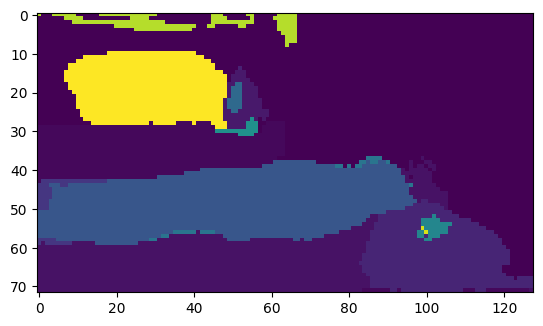

In [22]:
from PIL import Image
import numpy as np
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt


processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

def pad_to_square(image):
    # 获取原始图像的宽度和高度
    width, height = image.size
    # 计算新的正方形边长
    new_size = max(width, height)
    # 创建新的正方形图像，填充颜色为黑色（或其他你想要的颜色）
    new_image = Image.new("RGB", (new_size, new_size), (0, 0, 0))
    # 将原图粘贴到正方形图像的中心
    new_image.paste(image, ((new_size - width) // 2, (new_size - height) // 2))
    # top, bottom, left, right
    top = (new_size - height) // 2
    bottom = top + height
    left = (new_size - width) // 2
    right = left + width
    return new_image, new_size, top, bottom, left, right

def resize_image(image, size):
    # 将图像缩放到指定大小
    return image.resize(size)

# 读取图像
# image = Image.open('your_image.jpg')
image = Image.open("/home/anonymous/图片/20240620-145056.jpg")


# 将图像填充为正方形
square_image, new_size, top, bottom, left, right = pad_to_square(image)

# 将填充后的正方形图像缩放到 512x512
image = resize_image(square_image, (512, 512))

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# plot
predicted = torch.argmax(logits.squeeze(), dim=0)
predicted.shape

top, bottom, left, right = map(lambda x: int(x / new_size * predicted.shape[0]), [top, bottom, left, right])
# # resize to original size
# predicted = resize_image(predicted.cpu().numpy(), (new_size, new_size))
# # 裁剪掉填充区域
predicted_cropped = predicted[top:bottom, left:right]

plt.imshow(predicted_cropped.cpu().numpy())
plt.show()


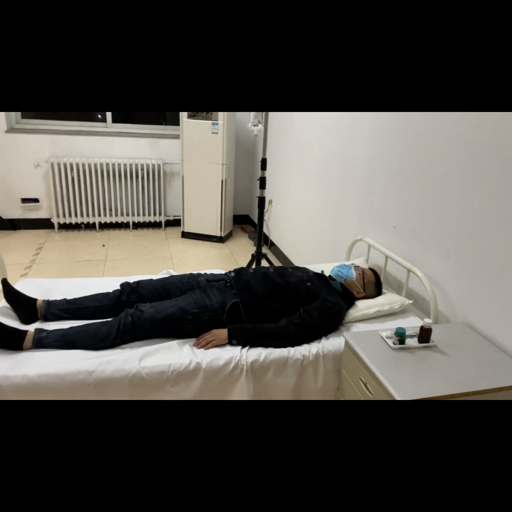

In [25]:
image

# 检测头

{'scores': tensor([0.5599, 0.4942, 0.6119, 0.2911, 0.2316]), 'labels': ['table', 'patient', 'bed', 'bottle', 'bottle'], 'boxes': tensor([[8.4162e+02, 5.2135e+02, 1.2790e+03, 7.1834e+02],
        [1.2489e+00, 3.7496e+02, 9.5849e+02, 6.0043e+02],
        [5.5729e-01, 3.0972e+02, 1.0967e+03, 7.1826e+02],
        [1.0431e+03, 5.1431e+02, 1.0825e+03, 5.8007e+02],
        [9.8192e+02, 5.3623e+02, 1.0170e+03, 5.8297e+02]])}


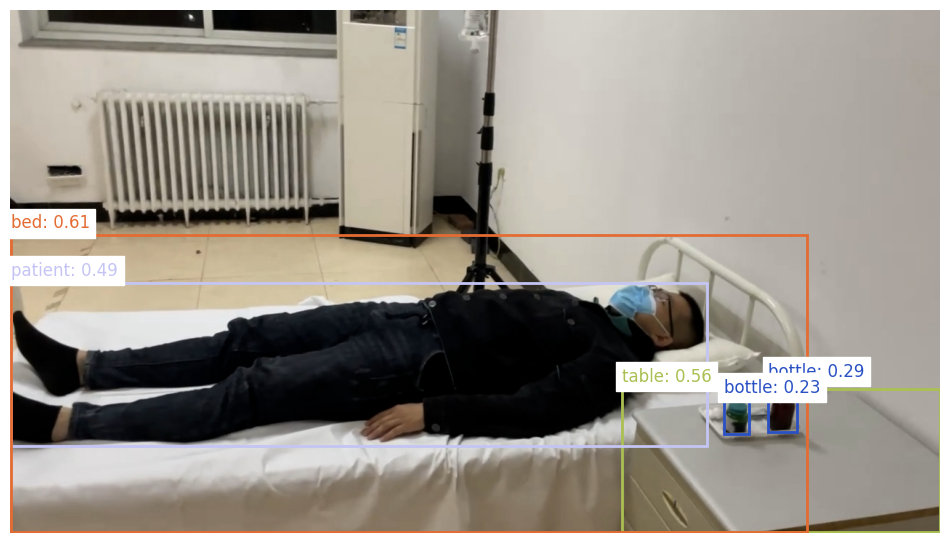

In [56]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

# image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(image_url, stream=True).raw)
image = Image.open("20240620-145056.jpg")
# Check for cats and remote controls
# VERY important: text queries need to be lowercased + end with a dot
text = "nurse. air conditioner. bed. chair. table. bottle. screen. computer. patient. medicine. cup. Infusion bottle stand. "

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.2,
    text_threshold=0.2,
    target_sizes=[image.size[::-1]]
)

print(results[0])
labels_set = set(results[0]['labels'])
# randomly map each label to a color
labels2colors = {label: np.random.rand(3,) for label in labels_set}


fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(image)

for item in results:
    scores = item['scores']
    labels = item['labels']
    boxes = item['boxes']
    
    for score, label, box in zip(scores, labels, boxes):
        color = labels2colors[label]
        # 绘制监测框
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # 添加标签和确信度
        plt.text(box[0], box[1] - 10, f'{label}: {score:.2f}', color=color, fontsize=12, backgroundcolor='white')

plt.axis('off')  # 关闭坐标轴
plt.show()


In [38]:
import numpy as np

labels_set = set(results[0]['labels'])
# randomly map each label to a color
labels2colors = {label: np.random.rand(3,) for label in labels_set}
# # create a color map for the image
# cmap = {label: labels2colors[label] for label in labels_set}
# cmap

In [39]:
np.random.rand(3,)

array([0.41015635, 0.7404459 , 0.6690304 ])

In [40]:
labels2colors

{'bed': array([0.79750431, 0.86975009, 0.00155356]),
 'patient': array([0.72554839, 0.11091925, 0.82405692]),
 'table': array([0.89665476, 0.47952565, 0.30082407]),
 'person': array([0.33194322, 0.34420391, 0.99923149])}

# 图像编码器 CLIP

In [3]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities


/home/anonymous/anaconda3/envs/nursingllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
model.vision_model#(image)

CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (position_embedding): Embedding(257, 1024)
  )
  (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-23): 24 x CLIPEncoderLayer(
        (self_attn): CLIPAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias

In [5]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [60]:
outputs.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

In [74]:
outputs.logits_per_image, outputs.logits_per_text

(tensor([[18.9041, 11.7159]], grad_fn=<TBackward0>),
 tensor([[18.9041],
         [11.7159]], grad_fn=<MulBackward0>))

In [67]:
outputs.vision_model_output.last_hidden_state.shape

torch.Size([1, 257, 1024])

In [73]:
outputs.text_model_output.last_hidden_state.shape

torch.Size([2, 7, 768])

In [69]:
outputs.image_embeds.shape

torch.Size([1, 768])

In [71]:
outputs.text_embeds.shape

torch.Size([2, 768])

In [58]:
probs

tensor([[9.9925e-01, 7.5487e-04]], grad_fn=<SoftmaxBackward0>)